### Data Collection

In [3]:
from bs4 import BeautifulSoup
import requests
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Define the base URL for scraping British Airways reviews from AirlineQuality (Skytrax)
# This will serve as the starting point for constructing paginated URLs

base_url = 'https://www.airlinequality.com/airline-reviews/british-airways'

# Each review page can display up to 100 reviews
page_size = 100

# We'll scrape the first 40 pages of reviews
total_pages = 40

# Initialize an empty list to hold all the review dictionaries
reviews = []

# Step 3: Loop through each review page using pagination
for page in range(total_pages + 1):
    print(f"Scraping page {page} of {total_pages} .........")

    # Construct the URL for the current page
    url = f'{base_url}/page/{page}/?sortby=post_date%3ADesc&pagesize={page_size}'

    # Send an HTTP GET request to the page
    response = requests.get(url)

    # Parse the response HTML using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Step 4: Extract all individual review containers from the HTML
    # Each review is wrapped in an <article> tag with itemprop="review"
    review_containers = soup.find_all('article', {'itemprop': 'review'})

    # Step 5: Loop through each review block and extract data
    for review in review_containers:
        review_dict = {}

        # Extract the title of the review
        title = review.find('h2', {'class': 'text_header'})
        review_dict['title'] = title.get_text(strip=True) if title else None

        # Extract the main review content
        content = review.find('div', {'class': 'text_content', 'itemprop': 'reviewBody'})
        review_dict['content'] = content.get_text(strip=True) if content else None

        # Extract the overall review rating (e.g., 7/10)
        # This is the actual numerical score submitted by the user
        rating_span = review.find('span', itemprop='ratingValue')
        if rating_span:
            try:
                review_dict['rating'] = int(rating_span.get_text(strip=True))
            except ValueError:
                # If the rating is not a valid integer, fall back to None
                review_dict['rating'] = None
        else:
            review_dict['rating'] = None

        # Extract the author's name (if available)
        author = review.find('span', {'itemprop': 'name'})
        review_dict['author'] = author.get_text(strip=True) if author else None

        # Extract the date the review was published
        date = review.find('time', {'itemprop': 'datePublished'})
        if date and date.has_attr('datetime'):
            review_dict['date'] = date['datetime']

        # Check whether the review is marked as "Trip Verified"
        # This helps assess the credibility of the review
        review_dict['verified'] = 'Trip Verified' in content.get_text() if content else False

        # Step 6: Extract additional structured information from the ratings table
        # This includes Aircraft, Route, Seat Type, Comfort, Cabin Staff, etc.
        rows = review.find_all('tr')  # Each <tr> represents a single attribute or rating category

        for row in rows:
            # First <td> is the label (e.g., "Aircraft")
            label_cell = row.find('td', {'class': 'review-rating-header'})
            # Second <td> is the value (e.g., "Boeing 777" or star ratings)
            value_cell = row.find('td', {'class': 'review-value'})

            if label_cell and value_cell:
                # Format the label to be lowercase and underscore-separated for consistency
                key = label_cell.get_text(strip=True).lower().replace(' ', '_')

                # Check if the value includes star icons
                stars = value_cell.find_all('span', {'class': 'star fill'})

                if stars:
                    # If stars are present, count them as a numeric score
                    value = len(stars)
                else:
                    # Otherwise, extract the plain text (e.g., for Aircraft or Route)
                    value = value_cell.get_text(strip=True)

                # Add the field to the current review dictionary
                review_dict[key] = value

        # Step 7: Append the complete review dictionary to the master list
        reviews.append(review_dict)

    # Step 8: Sleep briefly to avoid overwhelming the server (polite scraping)
    time.sleep(2)

Scraping page 0 of 40 .........
Scraping page 1 of 40 .........
Scraping page 2 of 40 .........
Scraping page 3 of 40 .........
Scraping page 4 of 40 .........
Scraping page 5 of 40 .........
Scraping page 6 of 40 .........
Scraping page 7 of 40 .........
Scraping page 8 of 40 .........
Scraping page 9 of 40 .........
Scraping page 10 of 40 .........
Scraping page 11 of 40 .........
Scraping page 12 of 40 .........
Scraping page 13 of 40 .........
Scraping page 14 of 40 .........
Scraping page 15 of 40 .........
Scraping page 16 of 40 .........
Scraping page 17 of 40 .........
Scraping page 18 of 40 .........
Scraping page 19 of 40 .........
Scraping page 20 of 40 .........
Scraping page 21 of 40 .........
Scraping page 22 of 40 .........
Scraping page 23 of 40 .........
Scraping page 24 of 40 .........
Scraping page 25 of 40 .........
Scraping page 26 of 40 .........
Scraping page 27 of 40 .........
Scraping page 28 of 40 .........
Scraping page 29 of 40 .........
Scraping page 30 of 

In [6]:
df = pd.DataFrame(reviews)
df.to_csv('/Users/jahdovanterpool/Downloads/Projects/Sentiment Analysis/British_Airways_reviews.csv', index=False)

### Data Preprocessing

In [55]:
reviews_df = pd.read_csv('/Users/jahdovanterpool/Downloads/Projects/Sentiment Analysis/British_Airways_reviews.csv',index_col=False)

reviews_df.head()

,title,content,rating,author,date,verified,aircraft,type_of_traveller,seat_type,route,date_flown,recommended
0,“Pleasant cabin crew”,✅Trip Verified| Check in and security at T5 qu...,7.0,E Smyth,2025-04-09,True,A320,Family Leisure,Business Class,London Heathrow to Barcelona,April 2025,yes
1,"""one of the best BA First flights I’ve had""",Not Verified| LHR T5 BA Gold Wing worked well...,9.0,Robert Bone,2025-04-03,False,Boeing 777 200,Business,First Class,London to Seattle,April 2025,yes
2,"""Very good service on this route""",Not Verified| Very good service on this route...,10.0,J Jones,2025-03-31,False,A320,Couple Leisure,Business Class,London Gatwick to Fuerteventura,March 2025,yes
3,"""disagreeable flight attendant""",✅Trip Verified| Flight mainly let down by a ...,7.0,J Meares,2025-03-19,True,Boeing 787,Solo Leisure,Business Class,Cape Town to London,March 2025,yes
4,"""flight was delayed nearly 1 hour""",✅Trip Verified| Another awful experience by ...,1.0,Luis De Jesus,2025-03-16,True,NaN,Business,Business Class,London to Geneva,December 2024,no


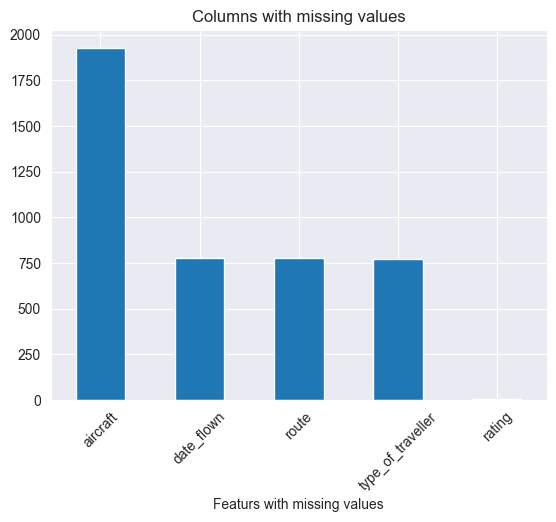

In [21]:
top_missingValue_columns = reviews_df.isnull().sum()\
    .sort_values(ascending=False)\
        .head()

top_missingValue_columns.plot(kind='bar',rot=45)

plt.title('Columns with missing values')

plt.xlabel('Features with missing values')
plt.show()

In [53]:
# I will focus on a basic sentiment analysis (content & rating)
reduced_df = reviews_df.drop(columns=['aircraft','type_of_traveller','route','date_flown'],axis=0)